## For use in regression, we need to get observations X (N, H) matrices, and Y (N, T) matrices.
####  N is the number of participants in our study. H can be one of three things: 4-digit MHC haplotypes, SNPs in the MHC region, and AAs in the classical MHC genes (e.g. DQB1). T is the number of V/J genes whose expression we are interested in Thus X holds genotypes for every individual, and Y holds the expression values of V/J genes for every individual.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import pickle

In [5]:
# crucially, gprobs contains the SNP2HLA imputations for all of the SNPs, AAs and MHC haplotypes that we desire
gprobs_path = "/labs/mignot/DGN/Genotypes_DGN/DGNGeno.dosage" # each person number between 0 and 2
fam_path = "/labs/mignot/DGN/Genotypes_DGN/DGNGeno.fam" # use the first column to get the order of patients in gprobs

In [6]:
patids = []
with open(fam_path, "r") as f:
    for line in f:
        patids.append(line.split()[0].split("_")[-1])
patids = patids[:937]
print(len(patids)) # the first 937 start with "LD" and are in the study

937


In [7]:
DQB10301_AA = 'MSWKKALRIPGGLRAATVTLMLAMLSTPVAEGRDSPEDFVYQFKAMCYFTNGTERVRYVTRYIYNREEYARFDSDVEVYRAVTPLGPPDAEYWNSQKEVLERTRAELDTVCRHNYQLELRTTLQRRVEPTVTISPSRTEALNHHNLLVCSVTDFYPAQIKVRWFRNDQEETTGVVSTPLIRNGDWTFQILVMLEMTPQHGDVYTCHVEHPSLQNPITVEWRAQSESAQSKMLSGIGGFVLGLIFLGLGLIIHHRSQKG'
DQB10301_position_AA_dict = dict()
for i, AA in enumerate(DQB10301_AA):
    DQB10301_position_AA_dict[i-31] = AA

In [8]:
# """For each amino acid position of some gene, produce a list of possible AAs that can occur"""
# position_AA_dict = dict() # {(position: list(AA)}
# position_AA_dosage_dict = dict() # {(position, AA): np.array(dosage)}

# ### position_AA_dict: key is position in gene, value is all of the possible AAs at that posiiton
# ### this dict should be unrelated to the dataset itself, I just used the DGN gprobs "AA_DQB1" header (no patient data)

# ### position_AA_dosage_dict: this contains DGN-specific data. 
# ### Key is (position, AA), and value is an array of imputed dosages, one entry for each patient.

# with open(gprobs_path, "r") as f:
#     for line in f:
#         tokens = line.split()
#         name = tokens[0]
#         dosages = np.array([float(dosage) for dosage in tokens[3:]])
#         #print(name)
#         if name.startswith("AA_DQB1"):
#             name_tokens = name.split("_")
#             if len(name_tokens) == 4: # only two alleles
#                 _, _, position, SNP = name_tokens
#                 position = int(position)
#                 AA1, AA2 = tokens[1], tokens[2]
#                 position_AA_dict[position] = [AA1, AA2]
#                 position_AA_dosage_dict[(position, AA1)] = dosages
#                 position_AA_dosage_dict[(position, AA2)] = 2.0-dosages # AA2 is complement of AA1
#             elif len(name_tokens) == 5: # multiple alleles, P/A
#                 _, _, position, SNP, AA = name_tokens
#                 position = int(position)
#                 if position not in position_AA_dict:
#                     position_AA_dict[position] = []
#                 position_AA_dict[position].append(AA)
#                 position_AA_dosage_dict[(position, AA)] = dosages
#             else:
#                 print("Error! {}".format(name))

In [9]:
### TODO: check with IMGT!!
# pickle.dump(position_AA_dict, open("DGN_position_AA_dict.pkl", "wb"))
# pickle.dump(position_AA_dosage_dict, open("DGN_position_AA_dosage_dict.pkl", "wb"))
position_AA_dict = pickle.load(open("DGN_position_AA_dict.pkl", "rb"))
position_AA_dosage_dict = pickle.load(open("DGN_position_AA_dosage_dict.pkl", "rb"))

In [10]:
VDJ_df = pd.read_csv("DGN_vdj_usages.csv", index_col=0)

def get_AA_df(position):
    AA_df = pd.DataFrame(patids, columns=['patid'])
    for AA in position_AA_dict[position]:
        AA_df[AA] = position_AA_dosage_dict[(position, AA)][:937] # only take the first 937 people
        # TODO: only take the 860 (?) people from Sharon
    VDJ_AA_df = pd.merge(AA_df, VDJ_df, on="patid", how="inner")
    return VDJ_AA_df

def get_family_df(family, remove_outliers=False):
    family_df = VDJ_AA_df[VDJ_AA_df['family'] == family]
    if remove_outliers:
        quantile_low, quantile_high = family_df["usage_ratio"].quantile([0.025, 0.975]).values
        family_df = family_df[(family_df["usage_ratio"] > quantile_low) & (family_df["usage_ratio"] < quantile_high)]
    return family_df

def reg_plot_df(family_df, x_column_name, y_column_name):
    fig, ax = plt.subplots()
    #sns.violinplot(x=x_column_name, y=y_column_name, data=family_df, ax=ax)
    sns.regplot(x=x_column_name, y=y_column_name, data=family_df, x_estimator=np.mean, ax=ax, label="Mean Estimator")
    plt.title(family_df['family'].unique()[0])
    plt.legend()
    
def regress_get_pvalue(family_df, covariate_column_names, effect_column_name):
    X = family_df.loc[:, covariate_column_names].values
    y = family_df[effect_column_name].values
    XX = sm.add_constant(X)
    mod = sm.OLS(y, XX)
    res = mod.fit()
    #print(res.summary())
    return res.params[1], res.pvalues[1] # p-value of coefficient, coefficient

### for each AA position and each reference AA at that position, get correlation with the usage of every TCR family

* family_corrcoef_dict is dict with key: TCR family, value: (cohort_size_n, corrcoef, pvalue).
* ranked_families_corrcoef is a list of ranked TCR family names from highest absolute correlation coefficient to lowest.
* There is one pair of these dicts for every AA_position x reference_AA
* after generating these dicts we save to vdj_csvs/dqb1_position{}_0301_reference{}dosage_vdj_usage_correlation_results.csv

In [ ]:
import statsmodels.stats.multitest as multitest
import statsmodels.api as sm

family_pvalue_dict = dict()
family_corrcoef_dict = dict()
for position in position_AA_dict: #[26, 45, 55, 57]:
    if position != "x":
        for reference_AA in position_AA_dict[position]:
            VDJ_AA_df = get_AA_df(position)
            AA_options = position_AA_dict[position]
            for family in VDJ_AA_df['family'].unique():
                try:
                    family_df = get_family_df(family, remove_outliers=False)
#                     ## REGRESSION
#                     # can drop one variable as they add up to 2
#                     # alternately use AA_options[:-1] to control for other alleles
#                     slope, slope_p = regress_get_pvalue(family_df, reference_AA, "usage_ratio")
#                     family_pvalue_dict[family] = (len(family_df), slope, slope_p)

                    ## CORRELATION
                    dosage, usage_ratio = family_df[reference_AA], family_df["usage_ratio"]
                    corrcoef, pvalue = scipy.stats.pearsonr(dosage, usage_ratio)
                    family_corrcoef_dict[family] = (len(family_df), corrcoef, pvalue)
                except:
                    print("skipped {} due to error".format(family))
                    continue
                    
            ranked_families_corrcoef = sorted(family_corrcoef_dict, key=lambda x: -abs(family_corrcoef_dict[x][1]))        
            ns = []
            families = []
            corrcoefs = []
            pvalues = []
            for family in ranked_families_corrcoef:
                n, corrcoef, pvalue = family_corrcoef_dict[family]
                ns.append(n)
                families.append(family)
                corrcoefs.append(corrcoef)
                pvalues.append(pvalue)
            # get 5% FDR corrected p-values
            rejected, corrected_pvalues = multitest.fdrcorrection(pvalues)

            out_file = open("vdj_csvs/dqb1_position{}_0301_reference{}dosage_vdj_usage_correlation_results.csv".format(position, reference_AA), "w")
            out_file.write("index,family,n,pearsons_R,pvalue,5%FDR_corrected_pvalue,rejected\n")

            for i in range(len(families)):
                if rejected[i]:
                    sig = "*"
                else:
                    sig = ""
                out_file.write("{},{},{},{:.2e},{:.2e},{:.2e},{}\n".format(i+1,families[i],ns[i],corrcoefs[i],pvalues[i],corrected_pvalues[i],sig))
            out_file.close()

### now we want to plot the correlation data
* read from vdj_csvs/dqb1_position{}_0301_reference{}dosage_vdj_usage_correlation_results.csv

-4 P does not exist
-5 T does not exist
-9 A does not exist
-10 L does not exist
-18 R does not exist
-27 K does not exist


(251.0, 0.0)

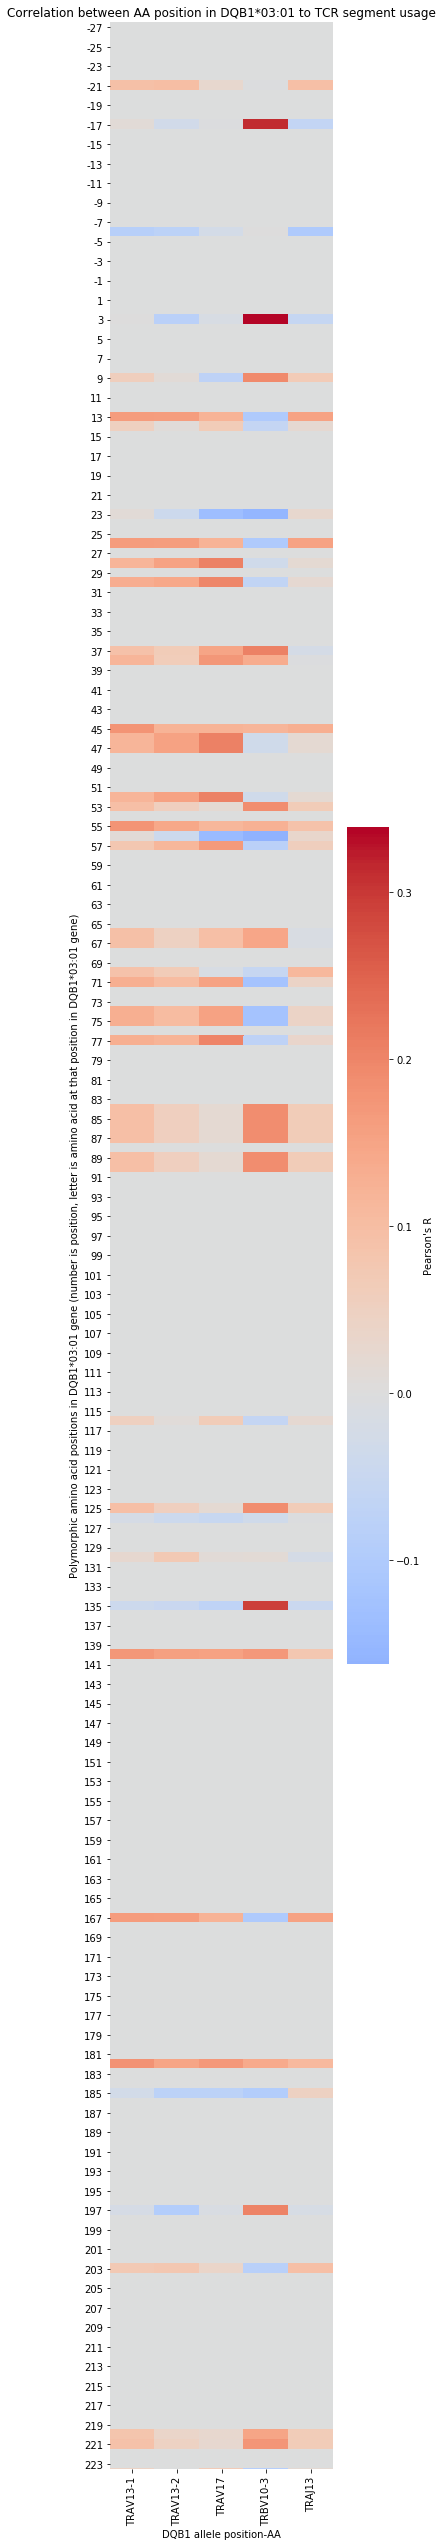

In [19]:
from functools import reduce
import seaborn as sns
import os

df_mergeds = []
for position in position_AA_dict: # [26, 45, 55, 57]
    DQB10301_AA = DQB10301_position_AA_dict[position]
    reference_AA = DQB10301_AA # only grab the case where reference_AA is the AA in DQB10301
    # print(position, position_AA_dict[position])
    dfs = []
    #for reference_AA in position_AA_dict[position]:
        #if reference_AA != "x":
    path = "vdj_csvs/dqb1_position{}_0301_reference{}dosage_vdj_usage_correlation_results.csv".format(position, reference_AA)
    
    if os.path.exists(path):
        df = pd.read_csv(path, index_col=0)
        #df = df[df["rejected"] == "*"]
        df = df[['family','pearsons_R']].rename(columns={"pearsons_R":position}) # str(position)+reference_AA
        dfs.append(df)
        df_merged = reduce(lambda left,right: pd.merge(left,right,on=['family'], how='outer'), dfs).fillna(0)
        df_mergeds.append(df_merged)
    else:
        print(position, reference_AA, "does not exist")


df_merged_merged = reduce(lambda left,right: pd.merge(left,right,on=['family'], how='outer'), df_mergeds).set_index("family").fillna(0)

## if we want to introduce vectors of zeros to fill in the positions with no AA variation
for position in range(-27, 225):
    if position not in df_merged_merged:
        df_merged_merged[position] = np.zeros((len(df_merged_merged)))
df_merged_merged = df_merged_merged.sort_index(axis=1)

#interested_genes = {"TRAV13-1", "TRAJ13", "TRAV17", "TRAV13-2", "TRAV20", "TRAV38-1", "TRAV8-4", "TRAJ48", "TRAV14/DV4"}
# interested_genes = ["TRAV23/DV6", "TRAV17", "TRAV13-1", "TRAV13-2", "TRBV10-3", "TRAV38-1", "TRAV12-1", "TRAJ31", "TRAV21", "TRAJ4", "TRAJ50"]
interested_genes = ["TRAV13-1", "TRAV13-2", "TRAV17", "TRBV10-3", "TRAJ13"]
interest_df = df_merged_merged[df_merged_merged.index.isin(interested_genes)]

interest_df = interest_df.reindex(interested_genes, axis=0)

fig, ax = plt.subplots(figsize=(len(interested_genes), 15*3))
ax = sns.heatmap(interest_df.transpose(), cmap='coolwarm', center=0, cbar_kws={'label': "Pearson's R"})
plt.xlabel("DQB1 allele position-AA".format(position))
plt.ylabel("Polymorphic amino acid positions in DQB1*03:01 gene (number is position, letter is amino acid at that position in DQB1*03:01 gene)")
plt.yticks(rotation=0)
plt.title("Correlation between AA position in DQB1*03:01 to TCR segment usage")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


In [16]:
df_merged_merged

,224Q,221H,220H,203I,197S,185T,182N,167H,140T,135D,...,215,216,217,218,219,220,221,222,223,224
family,,,,,,,,,,,,,,,,,,,,,
TRAV22,-0.158000,0.05620,0.03040,-0.005910,-0.0179,-0.084300,0.06800,0.0160,0.09420,0.01870,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAV12-1,-0.157000,0.01520,0.00415,0.006850,-0.0260,-0.000243,-0.07120,-0.0502,-0.05320,-0.04100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAJ14,-0.150000,-0.06230,-0.06370,-0.048800,-0.0330,0.005520,-0.08550,-0.0560,-0.06540,-0.00626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAV20,-0.145000,0.12300,0.10200,0.065900,-0.0451,-0.078700,0.12200,0.0871,0.15600,0.01660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAV16,-0.129000,-0.00166,0.00259,0.000869,0.0116,0.005950,-0.05030,-0.0515,-0.04940,-0.02280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAJ50,0.002060,-0.03360,-0.02790,-0.035500,0.0262,0.004470,-0.07830,-0.0898,-0.07530,-0.00709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRAJ39,0.002040,-0.06420,-0.05410,-0.019800,-0.0235,0.020000,-0.08320,-0.0456,-0.08050,-0.00182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TRBJ2-6,0.001830,-0.05780,-0.07090,-0.026900,-0.0626,-0.012900,-0.00806,0.0323,-0.00227,-0.06510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# ### Plotting

# import seaborn as sns
# from functools import reduce

# figsizes = {57:(5,10), 55:(2,15), 45:(1.3,5), 26:(2,10)}

# for position in figsizes.keys():
#     dfs = []
#     for reference_AA in position_AA_dict[position]:
#         path = "vdk_csvs/dqb1_position{}_0301_reference{}dosage_vdj_usage_correlation_results.csv".format(position, reference_AA)
#         df = pd.read_csv(path, index_col=0)
#         df = df[df["rejected"] == "*"]
#         df = df[['family','pearsons_R']].rename(columns={"pearsons_R":reference_AA})
#         dfs.append(df)
#     df_merged = reduce(lambda left,right: pd.merge(left,right,on=['family'], how='outer'), dfs).set_index("family").fillna(0)

#     fig, ax = plt.subplots(figsize=figsizes[position])
#     ax = sns.heatmap(df_merged, cmap='coolwarm',linewidths=0.1, center=0, cbar_kws={'label': "Pearson's R"}, square=True)
#     plt.xlabel("DQB1 {} allele".format(position))
#     plt.yticks(rotation=0) 
#     bottom, top = ax.get_ylim()
#     ax.set_ylim(bottom + 0.5, top - 0.5)